# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [3]:
# Install the surprise library that will be used to run the training of th recommendation models later on
%pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357271 sha256=5eef336a94df70d5c9b72c7a7ec2f0960a318d3ae9bab168c5f199ca1e8ff992
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [4]:
# prompt: read this notebook and import the relevant libraries

import warnings                                     # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                                  # Standard libraries in python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

'''
Unlike a regular dictionary, where trying to access a non-existent key raises a KeyError, a defaultdict allows you to specify a default value for missing keys.
This means if you access or modify a key that doesn't exist, it will automatically be created with the default value you provided.
Therefore this package creates a dictionary output that does not raise a key error
'''
from collections import defaultdict


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [6]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommendation Systems/Data/ratings_Electronics.csv', header = None) # Specify that there are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Add the required column names as instructed above

df = df.drop('timestamp', axis = 1) # Dropping the timestamp feature parameter

df_copy = df.copy(deep = True) # Copying the original data to another DataFrame as a backup

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [7]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [8]:
# We want our users to have at least 50 ratings to be considered. This will allow us to prune the data frame and reduce the data distribution to consider
RATINGS_CUTOFF = 50

# create an empty list to hold the users that we would like to remove, i.e. those with less than 50 ratings
remove_users = []

# please note that the variable users is the key and num_ratings is the value from the dictionary ratings_count above
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
"""
This statement below filters out rows from the DataFrame df where the user_id column contains values that are in the remove_users list above.
The filtered DataFrame is then reassigned to df, effectively removing those rows from the original DataFrame.
"""
df = df.loc[~ df.user_id.isin(remove_users)]      #

In [9]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [10]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

# create an empty list to hold the users that we would like to remove, i.e. those with less than 5 ratings
remove_users = []

# please note that the variable users is the key and num_ratings is the value from the dictionary ratings_count above
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
"""
This statement below filters out rows from the DataFrame df where the prod_id column contains values that are in the remove_users list above.
The filtered DataFrame is then reassigned to df, effectively removing those rows from the original DataFrame.
"""
df = df.loc[~ df.prod_id.isin(remove_users)]

In [11]:
# Print a few rows of the imported dataset
df.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [12]:
# Print a few of the last rows of the imported dataset
df.tail()

,user_id,prod_id,rating
7824423,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824424,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824425,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [13]:
# Check the number of rows and columns and provide observations
rows, columns = df.shape
print(f"No. of rows: {rows}")
print(f"No. of columns: {columns}")

No. of rows: 65290
No. of columns: 3


**Write your observations here:**

*   The data that we are going to be effectivley working on has reduced significantly
*   We have 3 columns and 65,290



### **Data types**

In [16]:
# Check Data types and provide observations
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:**

*   We have 3 columns named: user_id, prod_id, and rating respectively
*   Columns user_id, prod_id are of type object. It might be prudent to convert them to String and Integer respectively
*   Column rating is of data type float

In [17]:
'''
Columns user_id, prod_id are of type object.
From the .head() and .tail() functions above, user_id and prod_id contain combinations of letters & digits.
So we will convert the column to type 'string'
It might be prudent to convert them to String and Integer respectively.
In summary, this operation ensures that all values in the 'user_id' and 'prod_id' columns are treated as strings.
'''
df['user_id'] = df['user_id'].astype(str)
df['prod_id'] = df['prod_id'].astype(str)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


### **Checking for missing values**

In [18]:
# Check for missing values present and provide observations
# Let's check for missing values in the data and return it as a percentage rounded off to 2 decimal places
round(df.isnull().sum() / df.isnull().count() * 100, 2)

,0
user_id,0.0
prod_id,0.0
rating,0.0


In [19]:
# Checking for duplicate values in the data
df.duplicated().sum()

0

**Write your observations here:**

* There are no empty or missing data sets in this data frame.
* Every row and column has a value
* There are no duplicated values anywhere in the data frame

### **Summary Statistics**

In [20]:
# Summary statistics of 'rating' variable and provide observations
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:**
The summary statistics provided in the table describe the distribution of a rating variable. Here's a brief analysis of each metric:
* Count (65290.0): This indicates that there are 65,290 ratings in the dataset.

* Mean (4.294808): The average rating is approximately 4.29. This suggests that, on average, users tend to give relatively high ratings.

* Standard Deviation (0.988915): The standard deviation is around 0.99, indicating that the ratings deviate from the mean by approximately 1 point on average. Given that the rating scale seems to range from 1 to 5, this is a moderate level of variability.

* Min (1.0): The minimum rating is 1, which is likely the lowest possible rating on the scale.

* 25% (4.0): This is the first quartile, meaning that 25% of the ratings are 4 or below. This confirms that most users give ratings that are relatively high.

* 50% (5.0): The median (50th percentile) rating is 5.0. This suggests that at least half of the users rate items at the maximum value, indicating a skew towards high ratings.

* 75% (5.0): The third quartile is also 5.0, meaning that 75% of the ratings are 5 or below. This further reinforces the trend of high ratings.

* Max (5.0): The maximum rating is 5, which is likely the highest possible rating on the scale.

Final Observation:

The data is highly skewed towards higher ratings, with the majority of ratings clustered around 4 and 5. This might suggest that users generally rate positively or that the items being rated are of high quality. The relatively low standard deviation indicates that while there is some variation, most ratings are close to the mean of 4.29.

### **Checking the rating distribution**

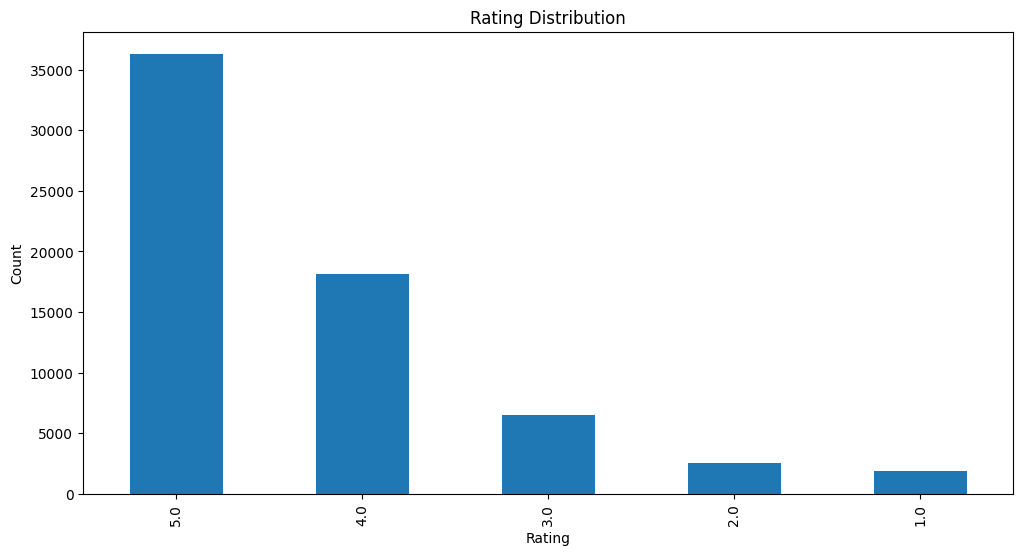

In [21]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 6))

df['rating'].value_counts().plot(kind = "bar")

# Name the xlabel of the plot
plt.xlabel('Rating')

# Name the ylabel of the plot
plt.ylabel('Count')

# Name the title of the plot
plt.title('Rating Distribution')

plt.show()

**Write your observations here:**
* We have a very high number of 5.0 ratings (*~36K*), followed by 4.0 (*~18K*), 3.0 (*~7K*), 2.0 (*~3K*) and 1.0 (*~2K*) respectively.

* We could infer that the high number of ratings may mean that the products are of high quality or that Amazon's users generally rate highly on average. This would need further exploration against other data sets to clear this ambiguity

### **Checking the number of unique users and items in the dataset**

In [22]:
# Number of total rows in the data and number of unique user id and product id in the data
uid = df['user_id'].nunique()
pid = df['prod_id'].nunique()

print(f"Total number of rows: {rows}")
print(f"Total number of unique users: {uid}")
print(f"Total number of unique products: {pid}")

Total number of rows: 65290
Total number of unique users: 1540
Total number of unique products: 5689


**Write your observations here:**
* Relative to the number of entries, (65,290), we have relatively few unique users.

* This could mean that we have very many repeat customers who potentially bought more than one product and rated them individually.

* We have potentially 1540 * 5689 = **8761060** ratings that can be generated. However we only have a set of 65290 ratings.

* This implies that not every user has rated every producted in the dataset.

* This means that we can build a recommendation system to recommend products to users who have not yet interacted with them.

* Given the fact that we have a pool of very active users, who seem to repeat purchase, they should be the first ones to have the other products exposed to them.

### **Users with the most number of ratings**

In [23]:
df.groupby(['user_id', 'prod_id']).count()

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [24]:
df.groupby(['prod_id', 'user_id']).count().sort_values(by = 'rating', ascending = False)

rating
prod_id    user_id               
1400501466 A19N3S7CBSU6O7       1
B0079R8KO0 A36A1ZYZH8568P       1
B0079MX4Q4 A3JNBO7H2SPL44       1
           ADLVFFE4VBT8         1
           AFM7FK7NFEKFZ        1
...                           ...
B002U6KT8U A17HMM1M7T9PJ1       1
           A1L5TA5UQF7EWE       1
           A1VR1HIOVQWN09       1
           A2SATO5BNKWY3Y       1
B00LGQ6HL8 A34BZM6S9L7QI4       1

[65290 rows x 1 columns]

In [25]:
df.groupby(['user_id', 'prod_id']).count().sort_values(by = 'rating', ascending = False)

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
A3KNGMX2RVQG91 B007M50PTM       1
               B001ASU1QO       1
               B001ENW61I       1
               B001EZYMF4       1
...                           ...
A292TRC6DX2GKK B0052SCU8U       1
               B0053G6GI6       1
A294BKN913UOGP B00005LEN4       1
               B000144I2Q       1
AZOK5STV85FBJ  B00FB2XNCE       1

[65290 rows x 1 columns]

In [26]:
# Top 10 users based on the number of ratings
df['user_id'].value_counts().sort_values(ascending = False).head(10)

,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


**Write your observations here:**
* The EDA above shows that there is essentially one interaction between a user and a product.
* The top 10 users above have extremely active interactions with the website and have bought and rated different products.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [27]:
# Calculate the average rating for each product
average_rating = df.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
df_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

# Sort the dataframe by average of ratings in the descending order
#dt = df_rating.groupby(['prod_id','avg_rating', 'rating_count']).count().sort_values(by = 'avg_rating', ascending = False)
dt = df_rating.sort_values(by = 'avg_rating', ascending = False)

# Assign the result above to a dataframe called "final_rating"
final_rating = pd.DataFrame(dt)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [28]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_prods(data, n, min_interaction=100):

    # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [29]:
res = list(top_n_prods(final_rating, 5, 50))
# Product ID of the products
list_of_prods = []
for i in res:
    list_of_prods.append(df[df['prod_id']== str(i) ]['prod_id'].unique()[0])
list_of_prods

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [30]:
res = list(top_n_prods(final_rating, 5, 100))
# Product ID of the products
list_of_prods = []
for i in res:
    list_of_prods.append(df[df['prod_id']== str(i) ]['prod_id'].unique()[0])
list_of_prods

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [72]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [32]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

**Let's encode the user_id and prod_id for simplicity, also encoding them will not make any change in the prediction.**


In [33]:
from sklearn.preprocessing import LabelEncoder
data=df[['user_id','prod_id']].apply(LabelEncoder().fit_transform)
data['rating']=df['rating']
data.head()

,user_id,prod_id,rating
1310,1050,0,5.0
1322,125,0,1.0
1335,785,0,3.0
1451,1495,0,5.0
1456,164,0,1.0


Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [70]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id','prod_id','rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [35]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options,verbose=False)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Write your observations here:**
* We can observe that the baseline model has a **Root Mean Square Error** `RMSE=1.0012` on the test set.

* Intuition of Precision - We are getting a **precision of ~ 0.855**, which means **out of all the recommended products, 85.5% are relevant**.

* Intuition of Recall - We are getting a **recall of ~0.858**, which means out of **all the relevant products, 85.8% are recommended**.

* Here **F_1 score** of the **baseline model is ~0.856**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. We can try to improve the performance by using **GridSearchCV to tune different hyperparameters** of the algorithm.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [36]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:**
* We observe that the actual rating for this user-product pair is 5.0 and predicted rating is 3.4 by this similarity based baseline model, which shows room for improvement. We were expecting a score closer to 5.0

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [37]:
# Find unique user_id where prod_id is not equal to "1400501466"
df[df.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

In [38]:
# Confirm that unique user_id A34BZM6S9L7QI4 is indeed in the list where prod_id is not equal to "1400501466"
df[(df.prod_id != "1400501466") & (df.user_id == "A34BZM6S9L7QI4")].user_id.unique()

array(['A34BZM6S9L7QI4'], dtype=object)

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [39]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
* We observe that the predicted rating for this user-product pair is 4.29 by this user-user similarity based baseline model, which shows a fairly good response.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [41]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9715477910186475
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [42]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, random_state = 1, verbose=False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


**Write your observations here:**
* We can observe that the baseline model has a **Root Mean Square Error** `RMSE=0.9526` on the test set. This shows a marked improvement due to the lower RMSE score.

* Intuition of Precision - We are getting a slightly degraded **precision of ~ 0.847**, which means **out of all the recommended products, 84.7% are relevant**.

* Intuition of Recall - We are getting an improved **recall of ~0.894**, which means out of **all the relevant products, 89.4% are recommended**.

* Here **F_1 score** of the **baseline model is ~0.87**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. In general, after hyperparameter tuning, the F_1 Score has improved, which indicates that in general, the model is better tuned compared to before.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [43]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [44]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
* There is no difference in the prediction of the baseline model and the tuned model for this particular user-product pair. Both models predicted the rating as 4.29, which is closer to the actual rating of 5.0 than the previous prediction of 3.40

* The lack of enough neighbours could be interfering with the prediction accuracy of this model.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [45]:
# 0 is the inner id of the above user, so pad it below as the first parameter of the .get_neighbours function
sim_user_user_optimized.get_neighbors(0, k=5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [46]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [47]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [48]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5.0
1,B000BQ7GW8,5.0
2,B001TH7GUU,5.0
3,B005ES0YYA,5.0
4,B00834SJSK,5.0


**Computing and Capturing Corrected product ratings**

While comparing the ratings of two products, it is not only the **ratings** that describe the **likelihood of the user to that product**.
Along with the rating the **number of users who have interacted with that product** also becomes a important point to consider.
Due to this, we have calculated the **"corrected_ratings"** for each product. Commonly, the higher the **"rating_count" of a product, then the more reliable the rating is**.
To interpret the above concept, a **product rated 4.4 with rating_count 5 is less liked in comparison to a product rated 4.0 with a rating count of 50**.
It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [49]:
"""
The function definition below is related to the mardow cell above relating to the "corrected_ratings".
"""

def ranking_products(recommendations, final_rating):
  # Sort the books based on ratings count
  ranked_prods = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # Merge with the recommended books to get predicted ratings
  ranked_prods = ranked_prods.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  # Rank the books based on corrected ratings
  ranked_prods['corrected_ratings'] = ranked_prods['predicted_ratings'] - 1 / np.sqrt(ranked_prods['rating_count'])

  # Sort the books based on corrected ratings
  ranked_prods = ranked_prods.sort_values('corrected_ratings', ascending=False)

  return ranked_prods

In [50]:
# Applying the ranking_products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5.0,4.900496
1,B001TH7GUU,78,5.0,4.886772
2,B000BQ7GW8,54,5.0,4.863917
3,B000067RT6,41,5.0,4.843826
4,B005ES0YYA,26,5.0,4.803884


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [51]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:**
Compared to the user-user training value:-

* We can observe that the baseline model has a **Root Mean Square Error** `RMSE=0.9950` on the test set. This shows a marked improvement to the user-user training value of 1.0012.

* Intuition of Precision - We are getting a slightly degraded **precision of ~ 0.838**, which means **out of all the recommended products, 83.8% are relevant**. The user-user training set value gave us 0.855

* Intuition of Recall - We are getting a degraded **recall of ~0.845**, which means out of **all the relevant products, 84.5% are recommended**. The user-user training set value gave us 0.858

* Here **F_1 score** of the **baseline model is ~0.841**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. In general, after hyperparameter tuning, the F_1 Score degraded comparatively, which indicates that in general, the model may not be better trained compared to the user-user model which had a score of 0.856

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [52]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**Write your observations here:**
* We observe that the actual rating for this user-product pair is 5.0 and predicted rating is 4.27 by this item-item similarity based baseline model, which shows room for improvement. We were expecting a score closer to 5.0

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [53]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

* We observe that the predicted rating for this user-product pair is 4.29 by this item-item similarity based baseline model, which shows a similar response compared to the earlier user-user similarity based baseline model.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [54]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Find the best RMSE score
print(grid_obj.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [60]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options={'name': 'msd',
             'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Write your observations here:**
Compared to the user-user training value:-

* We can observe that the baseline model has a **Root Mean Square Error** `RMSE=0.9576` on the test set. This shows a marked improvement to the item-item training value of 0.9950.

* Intuition of Precision - We are getting a very slightly improved **precision of ~ 0.839**, which means **out of all the recommended products, 83.9% are relevant**. The item-item training set value gave us 0.838

* Intuition of Recall - We are getting an improved **recall of ~0.88**, which means out of **all the relevant products, 88% are recommended**. The item-item training set value given earlier was 0.845

* Here **F_1 score** of the **baseline model is ~0.859**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. In general, after hyperparameter tuning, the F_1 Score improved comparatively, which indicates that in general, the model may be better trained compared to the item-item earlier training model which had a score of 0.841

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [63]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [64]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
* We observe that the actual rating for this user-product pair is 5.0 and predicted rating is 4.67 by this tuned item-item similarity based baseline model, which shows much better improvement and a score much closer to 5.0

* We observe that the predicted rating for `userId="A34BZM6S9L7QI4"` user-product pair is still 4.29 even by this improved item-item similarity based baseline model, which shows a similar response compared to the earlier tuned user-user similarity based baseline model.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [65]:
sim_item_item_optimized.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [66]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [67]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


In [68]:
# Applying the ranking_products function and sorting it based on the corrected ratings above
ranking_products(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


**General observations:**
* We can see that the item-item similarity has a lower predicted rating of 4.29 as opposed to the user-user similarity model which gave a predicted rating of 5.0

* The item-item similarity model als has a lower corrected rating of ~3.8 - 3.9 as opposed to the user-user similarity model which gave a corrected predicted rating of ~4.8 - 4.9

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [77]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8887
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Write your observations here:**
* We can observe that the baseline model has a **Root Mean Square Error** `RMSE=0.8887` on the test set. This shows a marked improvement due to the lower RMSE score.

* Intuition of Precision - We are getting a **precision score of ~ 0.853**, which means **out of all the recommended products, 85.3% are relevant**.

* Intuition of Recall - We are getting an improved **recall of ~0.88**, which means out of **all the relevant products, 88% are recommended**.

* Here **F_1 score** of the **baseline model is ~0.866**. It indicates that **mostly recommended products were relevant and relevant products were recommended**.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [78]:
# Making a prediction for a user with userID = A3LDPF5FMB782Z
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Write your observations here:**
* We observe that the actual rating for this user-product pair is 5.0 and predicted rating is 4.08 by this SVD similarity based model, which shows a score of 4.08 which is a bit lower than the user-user and the item-item similarity models

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [80]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Write your observations here:**

* We observe that the predicted rating for `userId="A34BZM6S9L7QI4"` user-product pair is 4.40 via this SVD based model, which shows a good improvement on the response compared to the earlier tuned user-user and item-item similarity based baseline models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [81]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
grid_obj2 = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
grid_obj2.fit(data)

# Best RMSE score
print(grid_obj2.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj2.best_params['rmse'])

0.8991740313408494
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [82]:
# Build the optimized SVD model using optimal hyperparameter search values from the output above. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)


RMSE: 0.8822
Precision:  0.854
Recall:  0.884
F_1 score:  0.869


**Write your observations here:**
Compared to the user-user training value:-

* We can observe that the baseline model has an improved **Root Mean Square Error** `RMSE=0.8822` on the test set. This shows a slight improvement to the SVD training value of 0.8887.

* Intuition of Precision - We are getting a very slightly improved **precision of ~ 0.854**, which means **out of all the recommended products, 83.9% are relevant**. The item-item training set value gave us 0.839

* Intuition of Recall - We are getting an improved **recall of ~0.884**, which means out of **all the relevant products, 88% are recommended**. The item-item training set value given earlier was 0.88

* Here **F_1 score** of the **baseline model is ~0.869**. It indicates that **mostly recommended products were relevant and relevant products were recommended**. In general, after hyperparameter tuning, the F_1 Score improved comparatively, which indicates that in general, the model may be better trained compared to the SVD earlier training model which had a score of 0.866

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [84]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0394144191097014, details={'was_impossible': False})

In [85]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.17   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.172649353607237, details={'was_impossible': False})

### **Conclusion and Recommendations**

- In this case study, we built recommendation systems using four different algorithms. They are as follows:
  - Rank-based using averages
  - User-user similarity-based collaborative filtering
  - Item-item similarity-based collaborative filtering
  - Model-based (matrix factorization) collaborative filtering

- To demonstrate **"user-user similarity-based collaborative filtering", "item-item similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering"**, **surprise** library has been used. For these algorithms, **grid search cross-validation is used to find the optimal hyperparameters for the data**, and improve the performance of the model**.

- **For performance evaluation** of these models, **precision@k and recall@k** are used. Using these two metrics, the F_1 score is calculated for each working model. The F_1 score or harmonic mean gives a balanced score of both the combined Precision and Recall scores.

- Overall, the **optimised user-user similarity-based recommendation system** has given the **best performance** in terms of the F1-Score (**~0.87**), very closely followed by the optimised **"model-based (matrix factorization) collaborative filtering"** recommendation system with a score of (**~0.869**)

- Collaborative Filtering searches for neighbors based on similarity of product preferences and then recommends products that those neighbors bought/interacted with while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- The **Matrix Factorization has the lowest RMSE (0.8822)** due to the reason that it **assumes that both products and users are present in some low dimensional space describing their properties and recommending a product based on its proximity to the user in the latent space.** Implying it accounts for latent factors as well.

- We could try to further improve the performance of these models using hyperparameter tuning.

- We could also try to combine different recommendation techniques to build a more complex model like hybrid recommendation systems.